In [1]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [2]:
#### Preprocecing ###

In [3]:
jh_dir = "../../COVID-19"

In [4]:
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [5]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()

In [6]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()

In [7]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [8]:
### Data Preparation ###

In [9]:
country = 'Japan'
epoch = pd.to_datetime('2020-01-22')
last = pd.to_datetime('2020-05-03')
C0 = confirmed.loc[epoch:last, country].values
R0 = (recovered).loc[epoch:last, country].values
D0 = death.loc[epoch:last, country].values
P = 12000_0000
iteration=2000
repeat = 1000

In [10]:
data = {'T': C0.shape[0], 'T0': 0, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0, 'q0':0.2, 'b_beta_0':0.1}

In [11]:
### Model ###

In [12]:
sm_const = pystan.StanModel(file="const.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_71cc90c309b0316ff5d2c42c3d218b94 NOW.


In [13]:
sm_every = pystan.StanModel(file="everyday.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_932cdbcc72157dc97c0d1bb55a6ba937 NOW.


In [14]:
sm_const_q = pystan.StanModel(file="everyday-const-q.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9dd31a91ba2222187c48a952f7561ebe NOW.


In [15]:
# Train the model and generate samples
inits = 'random'
fit_const = sm_const.sampling(data=data, iter=iteration, init=inits)
fit_const


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_71cc90c309b0316ff5d2c42c3d218b94.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf  23.24    0.06   4.44  15.07  20.16  23.05  26.08  32.82   5256    1.0
b          0.07  1.3e-5 7.3e-4   0.07   0.07   0.07   0.07   0.07   3428    1.0
q           1.0  6.4e-6 5.0e-4    1.0    1.0    1.0    1.0    1.0   6256    1.0
NI[1]      1.74    0.02   1.01   0.13   0.98   1.65   2.41    3.9   3449    1.0
NI[2]      1.82    0.02   1.07   0.17    1.0   1.69   2.51   4.17   3912    1.0
NI[3]      1.93    0.02   1.12   0.14   1.08   1.83   2.66   4.37   4446    1.0
NI[4]      3.12    0.02   1.08   1.17   2.36   3.08   3.81   5.41   5045    1.0
NI[5]      2.13    0.02   1.18   0.19   1.22   2.05   2.94   4.62   3667    1.0
NI[6]      3.81    0.02   1.17   1.71   2.97   3.76

In [16]:
# Train the model and generate samples
inits = 'random'
fit_every = sm_every.sampling(data=data, iter=iteration, init=inits)
fit_every


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_932cdbcc72157dc97c0d1bb55a6ba937.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   7.54    0.48   8.15   1.32   2.99   4.94   8.66  31.47    284   1.01
b_beta     0.01  2.1e-4 3.2e-3 5.9e-3 8.9e-3   0.01   0.01   0.02    217   1.01
b[1]       0.06  2.9e-3   0.06 1.4e-3   0.01   0.03   0.09    0.2    427   1.01
b[2]       0.08  2.9e-3   0.06 5.6e-3   0.03   0.07   0.13   0.22    423   1.01
b[3]        0.1  2.5e-3   0.06   0.01   0.06    0.1   0.14   0.22    509   1.01
b[4]       0.12  2.2e-3   0.05   0.03   0.08   0.12   0.15   0.23    577   1.01
b[5]       0.13  2.1e-3   0.05   0.04   0.09   0.13   0.16   0.24    540   1.01
b[6]       0.13  2.1e-3   0.05   0.05    0.1   0.13   0.16   0.24    535    1.0
b[7]       0.14  2.0e-3   0.05   0.06   0.11   0.13

In [17]:
print(fit_every)

Inference for Stan model: anon_model_932cdbcc72157dc97c0d1bb55a6ba937.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       7.54    0.48   8.15   1.32   2.99   4.94   8.66  31.47    284   1.01
b_beta         0.01  2.1e-4 3.2e-3 5.9e-3 8.9e-3   0.01   0.01   0.02    217   1.01
b[1]           0.06  2.9e-3   0.06 1.4e-3   0.01   0.03   0.09    0.2    427   1.01
b[2]           0.08  2.9e-3   0.06 5.6e-3   0.03   0.07   0.13   0.22    423   1.01
b[3]            0.1  2.5e-3   0.06   0.01   0.06    0.1   0.14   0.22    509   1.01
b[4]           0.12  2.2e-3   0.05   0.03   0.08   0.12   0.15   0.23    577   1.01
b[5]           0.13  2.1e-3   0.05   0.04   0.09   0.13   0.16   0.24    540   1.01
b[6]           0.13  2.1e-3   0.05   0.05    0.1   0.13   0.16   0.24    535    1.0
b[7]           0.14  2.0e-3   0.05   0.06   0.11   0.13

In [18]:
# Train the model and generate samples
inits = 'random'
fit_const_q = sm_const_q.sampling(data=data, iter=iteration, init=inits)
fit_const_q


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_9dd31a91ba2222187c48a952f7561ebe.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   5.59    0.72   3.55   1.43   2.91   4.56   7.34   14.6     24   1.17
b_beta     0.05  5.4e-4 6.7e-3   0.04   0.05   0.05   0.06   0.07    156   1.04
b[1]       0.15    0.02    0.1   0.02   0.07   0.13   0.19    0.4     25   1.19
b[2]       0.21    0.01    0.1   0.06   0.14   0.19   0.27   0.44     63   1.07
b[3]       0.25    0.01    0.1   0.07   0.18   0.25   0.32   0.47     60   1.05
b[4]        0.3    0.01    0.1   0.12   0.23    0.3   0.36   0.51     53   1.06
b[5]       0.32    0.01    0.1   0.15   0.25   0.32   0.38   0.52     50   1.08
b[6]       0.34    0.01   0.09   0.18   0.28   0.34    0.4   0.53     51   1.05
b[7]       0.34    0.01   0.09   0.18   0.27   0.33

In [19]:
# Save models

In [20]:
## Saving results

In [21]:
import pickle
with open("sm_const_fit-Japan.pkl", "wb") as f:
    pickle.dump({'model' : sm_const, 'fit' : fit_const}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
import pickle
with open("sm_every_fit-Japan.pkl", "wb") as f:
    pickle.dump({'model' : sm_every, 'fit' : fit_every}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
import pickle
with open("sm_const_q_fit-Japan.pkl", "wb") as f:
    pickle.dump({'model' : sm_const_q, 'fit' : fit_const_q}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
### Load modesl

In [25]:
with open("sm_const_fit-Japan.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_const = data_dict['model']
fit_const = data_dict['fit']
# fit = data_list[1]

In [26]:
with open("sm_every_fit-Japan.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_every = data_dict['model']
fit_every = data_dict['fit']
# fit = data_list[1]

In [27]:
with open("sm_const_q_fit-Japan.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_const_q = data_dict['model']
fit_const_Q = data_dict['fit']
# fit = data_list[1]

In [28]:
### model selection

In [29]:
data_const = az.from_pystan(fit_const, log_likelihood='log_lik')
data_every = az.from_pystan(fit_every, log_likelihood='log_lik')
data_const_q = az.from_pystan(fit_const_q, log_likelihood='log_lik')

In [30]:
#az.plot_trace(data_every, var_names=['b'])

In [31]:
#az.plot_trace(data_const, var_names=['b', 'q'])

In [32]:
loo_const = az.loo(data_const, pointwise=True)
loo_const

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo  4021.54   677.78
p_loo    996.11        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       28   27.5%
 (0.5, 0.7]   (ok)         26   25.5%
   (0.7, 1]   (bad)        12   11.8%
   (1, Inf)   (very bad)   36   35.3%

In [33]:
loo_every = az.loo(data_every, pointwise=True)
loo_every

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo   712.71    28.61
p_loo     79.64        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        7    6.9%
 (0.5, 0.7]   (ok)         10    9.8%
   (0.7, 1]   (bad)        71   69.6%
   (1, Inf)   (very bad)   14   13.7%

In [34]:
loo_const_q = az.loo(data_const_q, pointwise=True)
loo_const_q

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:759: RuntimeWarning: overflow 

Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo 101521.55  16982.43
p_loo  50288.41        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    1.0%
 (0.5, 0.7]   (ok)          1    1.0%
   (0.7, 1]   (bad)         2    2.0%
   (1, Inf)   (very bad)   98   96.1%

In [35]:
az.compare({'const':data_const, 'everyday':data_every, 'const-q':data_const_q})

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
everyday,0,658.266,52.4197,0,1,882.708,0,True,deviance
const,1,4920.45,1445.56,4262.18,0,26.8732,904.971,True,deviance
const-q,2,7.96421e+06,3.98163e+06,7.96355e+06,0,1.75155e+06,1.81037e+06,True,deviance


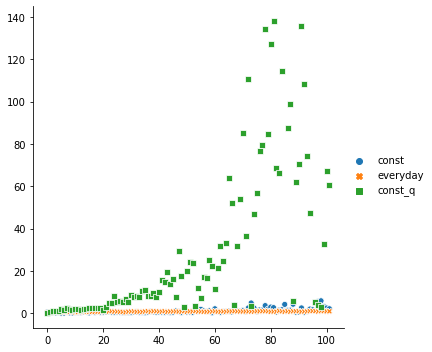

In [36]:
df = pd.DataFrame({'const':loo_const.pareto_k, 'everyday':loo_every.pareto_k, 'const_q':loo_const_q.pareto_k})
sns.relplot(data=df)

In [37]:
df.idxmax()

const       98
everyday    83
const_q     85
dtype: int64

In [38]:
def loo(sm):
    log_likelihood = 0
    for i in range(C0.shape[0]-1):
        print('\rNo, %d' % i, end='')
        data_LOO = {'T': C0.shape[0], 'T0': i+1, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}
        fit_loo = sm_const.sampling(data=data_LOO, iter=2000, init='random')
        data_loo = az.from_pystan(fit_loo, log_likelihood='log_lik')
        log_likelihood += data_loo.sample_stats['log_likelihood'].sel(log_likelihood_dim_0=i).mean()
        
    return log_likelihood

In [39]:
### Visualization ###

In [40]:
upto = epoch+pd.Timedelta(days=C0.shape[0]-2)
index= pd.date_range(start=epoch, end=upto)

In [41]:
#### Changing beta and q

In [42]:
init_inf_e = pd.DataFrame(data_every.posterior['b'].stack(sample=('chain', 'draw')).values)
b_e = pd.DataFrame(data_every.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
q_e = pd.DataFrame(data_every.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)
NI_e = pd.DataFrame(data_every.posterior['NI'].stack(sample=('chain', 'draw')).values, index=index)
a_e = pd.DataFrame(data_every.posterior['a'].stack(sample=('chain', 'draw')).values)
d_e = pd.DataFrame(data_every.posterior['d'].stack(sample=('chain', 'draw')).values)
C_e = NI_e.cumsum().shift(periods=1).fillna(0)
C_e = pd.DataFrame(np.array([C_e.iloc[i].values + init_inf_e.values[i] for i in range(C_e.shape[0])]), index=index)
NI0_e = q_e*NI_e
C0S_e = NI0_e.cumsum().shift(periods=1).fillna(0)
C0S_e = pd.DataFrame(np.array([C0S_e.iloc[i].values + C0[0] for i in range(C_e.shape[0])]), index=index)

In [43]:
def draw(simulated, real=None, upto=pd.to_datetime('2020-04-26'), line=None):
    graph=pd.DataFrame(index=pd.date_range(start=epoch, end=upto))
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    g=sns.relplot(kind="line", data=graph, aspect=2)
    ax = g.axes[0][0]
    if line is not None:
        ax.axhline(y = line, color='grey', linewidth=2, alpha=.7)
    plt.show()

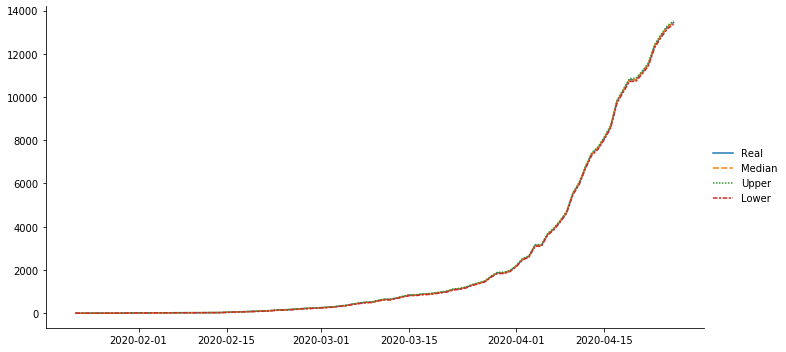

In [44]:
draw(C0S_e, real=confirmed[country])

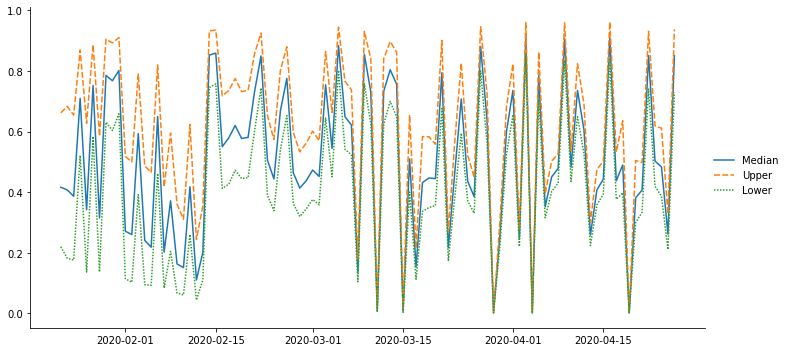

In [45]:
draw(q_e)

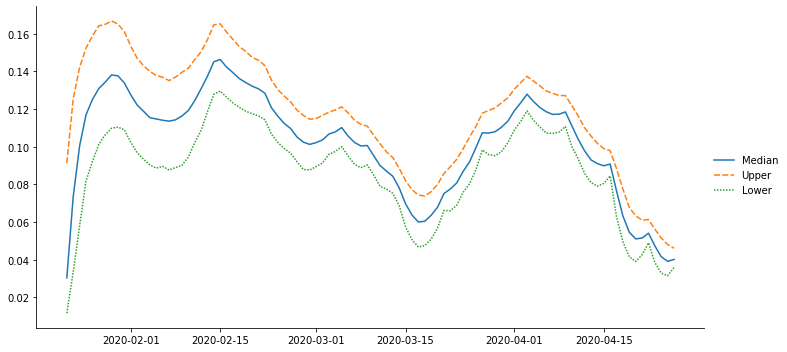

In [46]:
draw(b_e)

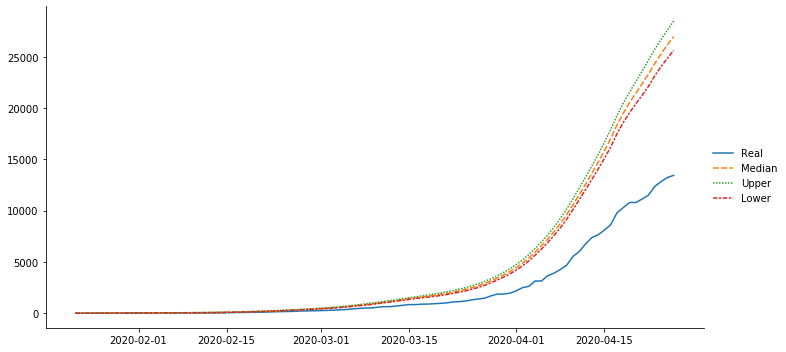

In [47]:
draw(C_e, real=confirmed[country])

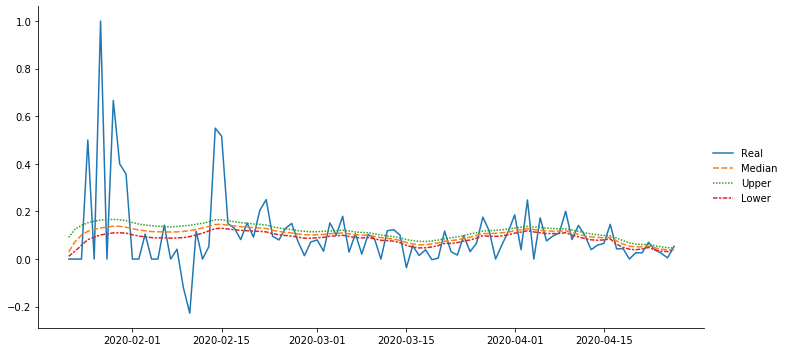

In [48]:
infected = (confirmed-recovered)[country]
r=infected.shift(-1)/infected-1
draw(b_e, real=r)

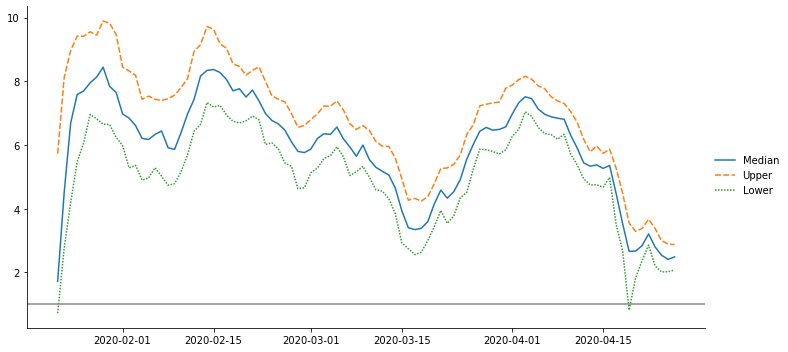

In [49]:
R = pd.DataFrame(np.array([(b_e[i].values / (a_e.iloc[i].values + d_e.iloc[i].values)) * (1 - C_e[i]/P) for i in range(len(b_e))]).T, index=b_e.index)
draw(R, line=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f93b7e366d0>],
      dtype=object)

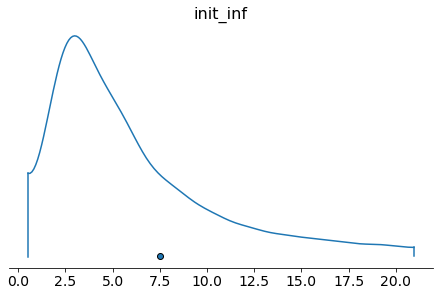

In [50]:
az.plot_density(data_every, var_names=['init_inf'])

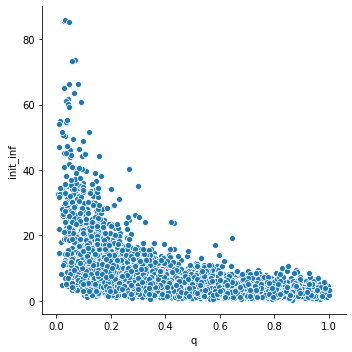

In [51]:
q = data_every.posterior['q'].stack(sample=('chain', 'draw')).sel(q_dim_0=0)
init_inf = data_every.posterior['init_inf'].stack(sample=('chain', 'draw'))
df = pd.DataFrame({'init_inf':init_inf.values, 'q':q.values})
sns.relplot(data=df, x='q', y='init_inf')

In [52]:
### constant detection rate

In [53]:
b_c = pd.DataFrame(data_const_q.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
NI_c = pd.DataFrame(data_const_q.posterior['NI'].stack(sample=('chain', 'draw')).values, index=index)
a_c = pd.DataFrame(data_const_q.posterior['a'].stack(sample=('chain', 'draw')).values)
d_c = pd.DataFrame(data_const_q.posterior['d'].stack(sample=('chain', 'draw')).values)
C_c = NI_c.cumsum().shift(periods=1).fillna(0)
C_c = pd.DataFrame(np.array([C_c.iloc[i].values + init_inf[0].values for i in range(C_c.shape[0])]), index=index)
NI0_c = data['q0']*NI_c
C0S_c = NI0_c.cumsum().shift(periods=1)
C0S_c = pd.DataFrame(np.array([C0S_c.iloc[i].values + C0[0] for i in range(C_c.shape[0])]), index=index)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


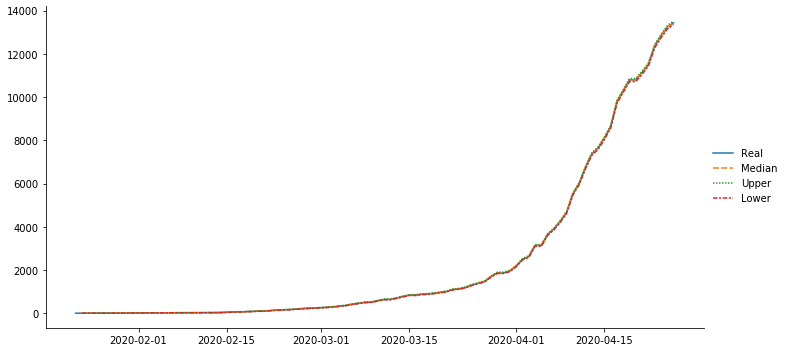

In [54]:
draw(C0S_c, real=confirmed[country])

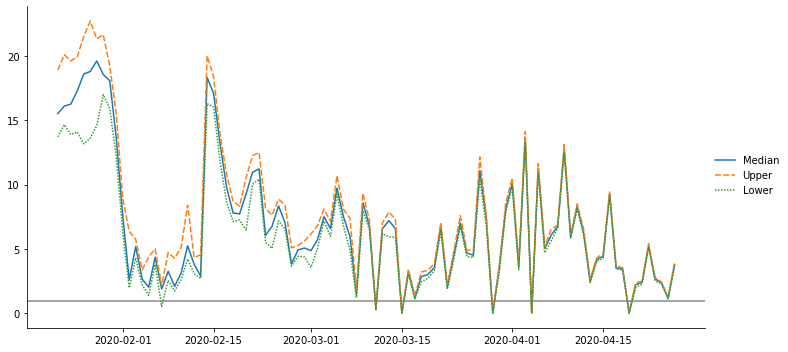

In [55]:
R = pd.DataFrame(np.array([(b_c[i].values / (a_c.iloc[i].values + d_c.iloc[i].values)) * (1 - C_c[i]/P) for i in range(len(b_e))]).T, index=b_e.index)
draw(R, line=1)

In [56]:
## Sensibility analysis

In [57]:
data_sen = data.copy()
data_sen['b_beta_0']=1

In [58]:
# Train the model and generate samples
inits = 'random'
fit_sens = sm_every.sampling(data=data_sen, iter=iteration, init=inits)
fit_sens


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_932cdbcc72157dc97c0d1bb55a6ba937.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   6.34    0.28   5.72   1.25   2.87   4.63   7.61   22.4    406   1.01
b_beta     0.01  2.0e-4 3.4e-3 6.9e-3   0.01   0.01   0.01   0.02    292   1.02
b[1]       0.06  2.1e-3   0.06 1.2e-3   0.01   0.03   0.08    0.2    730    1.0
b[2]       0.09  2.3e-3   0.06 7.2e-3   0.04   0.08   0.13   0.22    692    1.0
b[3]       0.11  2.0e-3   0.06   0.02   0.06    0.1   0.15   0.23    823    1.0
b[4]       0.13  1.8e-3   0.05   0.04   0.09   0.12   0.16   0.25    893    1.0
b[5]       0.13  1.8e-3   0.05   0.04    0.1   0.13   0.16   0.24    791    1.0
b[6]       0.14  1.6e-3   0.05   0.06   0.11   0.14   0.17   0.25    855    1.0
b[7]       0.14  1.6e-3   0.05   0.06   0.11   0.14

In [59]:
data_sens = az.from_pystan(fit_sens, log_likelihood='log_lik')

In [60]:
init_inf_sens = pd.DataFrame(data_sens.posterior['init_inf'].stack(sample=('chain', 'draw')).values)
b_sens = pd.DataFrame(data_sens.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
q_sens = pd.DataFrame(data_sens.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)



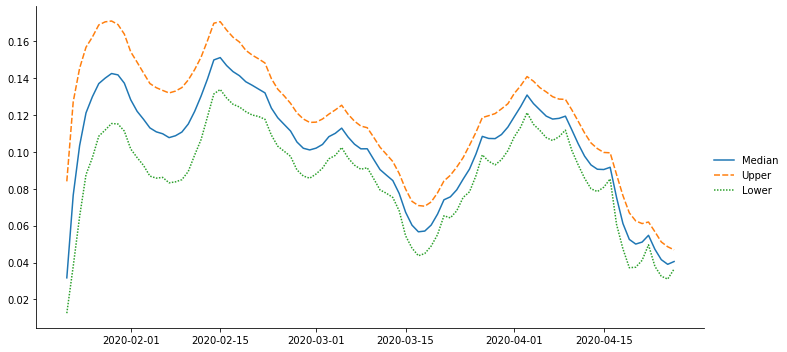

In [61]:
draw(b_sens)

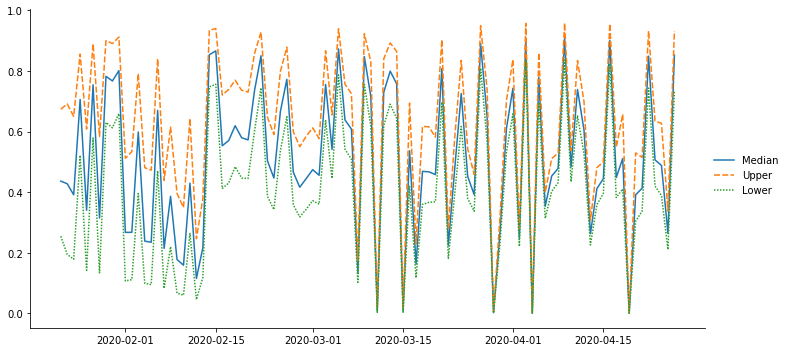

In [62]:
draw(q_sens)

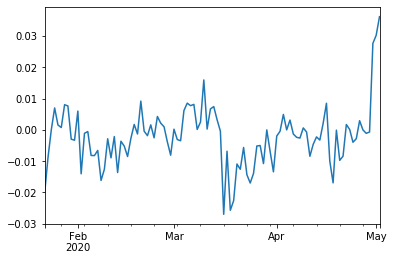

In [63]:
(q_e-q_sens).median(axis=1).plot()

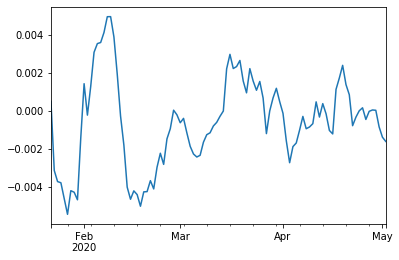

In [64]:
(b_e-b_sens).median(axis=1).plot()

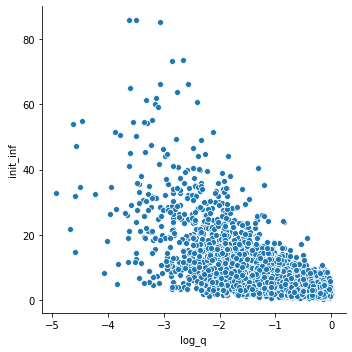

In [65]:
df = pd.DataFrame({'init_inf':init_inf.values, 'log_q':np.log(q.values)})
sns.relplot(data=df, x='log_q', y='init_inf')

In [66]:
## Validation by simualation

In [247]:
from scipy.stats import poisson
def simulate_const(b, q, init_inf, a, d, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C + NI
        R = R + NR
        D = ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        R_obs.append(int(R_obs[-1]+poisson.rvs(a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
    return {'C0':np.array(C_obs), 'R0':np.array(R_obs), 'D0':np.array(D_obs), 'T':C0.shape[0], 'T0':0, 'P':P, 'b_beta_0':1}

In [248]:
data_sim = simulate_const(0.07, 0.2, 100, 0.01, 0.001, index)

In [249]:
data_sim

{'C0': array([  18,   18,   19,   20,   20,   21,   25,   26,   26,   27,   28,
          29,   31,   35,   37,   41,   44,   48,   49,   58,   61,   64,
          65,   76,   80,   87,   91,   99,  103,  111,  117,  122,  134,
         138,  145,  150,  154,  158,  165,  178,  185,  197,  216,  231,
         247,  263,  281,  294,  318,  343,  365,  395,  424,  446,  473,
         505,  534,  572,  612,  655,  691,  731,  789,  827,  877,  927,
         978, 1023, 1087, 1157, 1243, 1314, 1379, 1464, 1544, 1635, 1739,
        1842, 1947, 2056, 2188, 2340, 2476, 2615, 2758, 2938, 3121, 3330,
        3515, 3727, 3972, 4202, 4412, 4686, 4969, 5245, 5533, 5820, 6196,
        6535, 6892, 7298, 7726]),
 'R0': array([   0,    1,    1,    2,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    4,    5,    5,    5,    5,    5,
           5,    5,    5,    6,    8,    8,   11,   13,   14,   16,   17,
          21,   22,   22,   23,   24,   25,   27,   32,   35,   37

In [250]:
# Train the model and generate samples
inits = 'random'
fit_sim = sm_every.sampling(data=data_sim, iter=iteration, init=inits)
inf_sim = az.from_pystan(fit_sim, log_likelihood='log_lik')
fit_sim


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_932cdbcc72157dc97c0d1bb55a6ba937.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf  45.48    3.46  35.67  14.26  23.72  34.52  54.32 143.35    106   1.01
b_beta   2.8e-3  1.1e-4 1.1e-3 1.2e-3 2.1e-3 2.7e-3 3.4e-3 5.5e-3     95   1.05
b[1]       0.02  1.6e-3   0.02 2.3e-4 2.3e-3 5.9e-3   0.02   0.08    203   1.02
b[2]       0.04  2.6e-3   0.03 2.2e-3   0.01   0.03   0.06   0.09    122   1.01
b[3]       0.04  2.4e-3   0.03 3.5e-3   0.02   0.04   0.07    0.1    132   1.01
b[4]       0.05  2.3e-3   0.03 5.9e-3   0.03   0.05   0.07    0.1    132   1.01
b[5]       0.05  2.2e-3   0.02 7.8e-3   0.03   0.05   0.07    0.1    128   1.01
b[6]       0.06  1.9e-3   0.02   0.01   0.04   0.06   0.07    0.1    143   1.01
b[7]       0.06  1.8e-3   0.02   0.02   0.04   0.06

In [251]:
b_sim = pd.DataFrame(inf_sim.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
q_sim = pd.DataFrame(inf_sim.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)

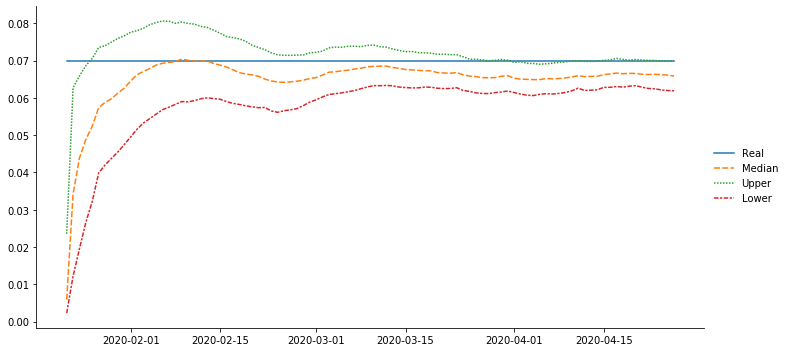

In [252]:
draw(b_sim, real=0.07)

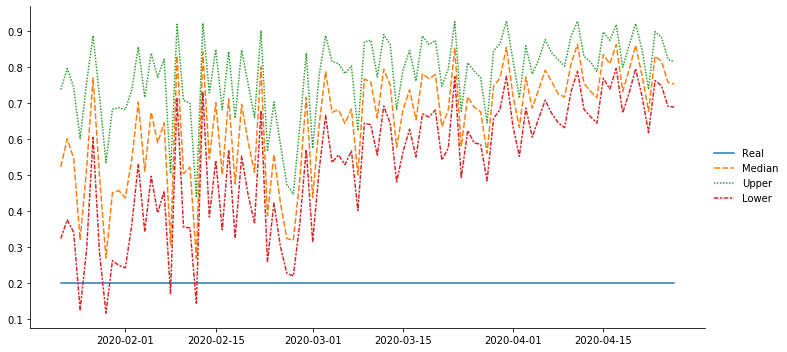

In [253]:
draw(q_sim, real=0.2)

In [254]:
# Train the model and generate samples
inits = 'random'
data_sim['q0']=1
fit_const_q = sm_const_q.sampling(data=data_sim, iter=iteration, init=inits)
inf_const_q = az.from_pystan(fit_const_q, log_likelihood='log_lik')
fit_const_q


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_9dd31a91ba2222187c48a952f7561ebe.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf  15.49    0.92   3.26  10.48  13.02  15.18  17.55  22.44     13   1.16
b_beta   1.6e-3  1.1e-4 5.9e-4 6.6e-4 1.2e-3 1.5e-3 1.8e-3 3.1e-3     27   1.18
b[1]       0.04    0.02   0.03 4.2e-5 2.1e-3   0.06   0.07   0.09      3   3.44
b[2]       0.06  5.5e-3   0.01   0.03   0.06   0.07   0.07   0.09      7   1.74
b[3]       0.06  5.4e-3   0.01   0.03   0.06   0.07   0.07   0.09      7    1.8
b[4]       0.06  5.3e-3   0.01   0.03   0.06   0.07   0.07   0.09      7   1.86
b[5]       0.07  5.2e-3   0.01   0.03   0.06   0.07   0.07   0.09      6   1.84
b[6]       0.07  4.6e-3   0.01   0.04   0.06   0.07   0.07   0.09      6   1.76
b[7]       0.07  4.6e-3   0.01   0.04   0.06   0.07

In [255]:
b_sim_const_q = pd.DataFrame(inf_const_q.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)

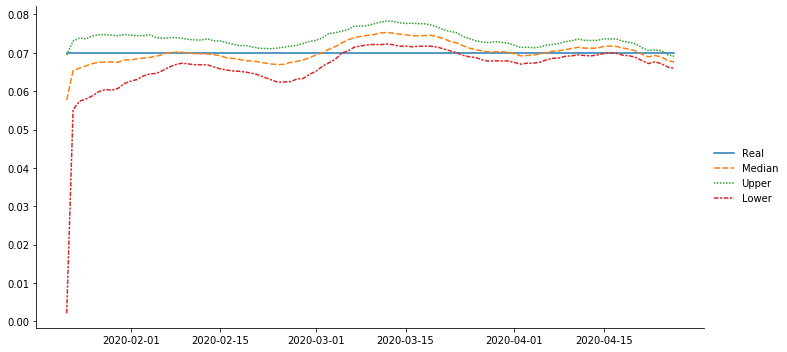

In [256]:
draw(b_sim_const_q, real=0.07)

In [257]:
from scipy.stats import poisson
def simulate_step(b, q1, q2, init_inf, a, d, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q1)]
    R_obs = [0]
    D_obs = [0]
    q=[]
    for t in index:
        if t < pd.to_datetime('2020-04-01'):
            q.append(q1)
        else:
            q.append(q2)
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C+NI
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        R_obs.append(int(R_obs[-1]+poisson.rvs(a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
    return {'C0':np.array(C_obs), 'R0':np.array(R_obs), 'D0':np.array(D_obs), 
            'T':C0.shape[0], 'T0':0, 'P':P, 'b_beta_0':1, 'q':np.array(q)}

In [258]:
data_sim = simulate_step(0.07, 1, 0.8, 1000, 0.01, 0.001, index)

In [259]:
data_sim

{'C0': array([  1010,   1071,   1139,   1217,   1305,   1373,   1462,   1588,
          1692,   1800,   1920,   2060,   2217,   2366,   2528,   2694,
          2858,   3037,   3241,   3462,   3692,   3917,   4144,   4408,
          4703,   4968,   5272,   5654,   6018,   6407,   6773,   7192,
          7613,   7993,   8447,   8981,   9553,  10117,  10761,  11437,
         12127,  12875,  13679,  14561,  15449,  16364,  17324,  18296,
         19374,  20475,  21767,  23082,  24405,  25791,  27330,  29020,
         30660,  32504,  34485,  36477,  38627,  40884,  43403,  46010,
         48758,  51641,  54722,  58019,  61398,  65014,  68888,  72270,
         75708,  79496,  83514,  87762,  92175,  96853, 101595, 106656,
        112188, 117558, 123730, 130046, 136788, 143807, 151473, 159527,
        168261, 177219, 186616, 196878, 207518, 219164, 231108, 243950,
        257406, 271789, 286927, 303092, 320127, 337994, 356835]),
 'R0': array([    0,     8,    14,    24,    33,    51,    67,  

In [260]:
# Train the model and generate samples
inits = 'random'
fit_sim = sm_every.sampling(data=data_sim, iter=iteration, init=inits)
inf_sim = az.from_pystan(fit_sim, log_likelihood='log_lik')

In [261]:
fit_sim


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_932cdbcc72157dc97c0d1bb55a6ba937.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf 1464.8    12.3 263.29 1064.0 1268.8 1429.8 1623.9 2077.6    458   1.01
b_beta   1.1e-3  4.4e-5 5.0e-4 4.0e-4 7.0e-4 9.8e-4 1.3e-3 2.3e-3    125   1.03
b[1]       0.07  2.8e-4 7.1e-3   0.05   0.06   0.07   0.07   0.08    621   1.01
b[2]       0.07  2.8e-4 7.1e-3   0.05   0.06   0.07   0.07   0.08    631   1.01
b[3]       0.07  2.9e-4 7.1e-3   0.05   0.06   0.07   0.07   0.08    613   1.01
b[4]       0.07  2.8e-4 7.1e-3   0.05   0.06   0.07   0.07   0.08    627   1.01
b[5]       0.07  2.8e-4 7.1e-3   0.05   0.06   0.07   0.07   0.08    624   1.01
b[6]       0.07  2.8e-4 7.0e-3   0.05   0.06   0.07   0.07   0.08    611   1.01
b[7]       0.07  2.8e-4 7.0e-3   0.05   0.06   0.07

In [262]:
b_sim = pd.DataFrame(inf_sim.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
q_sim = pd.DataFrame(inf_sim.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)

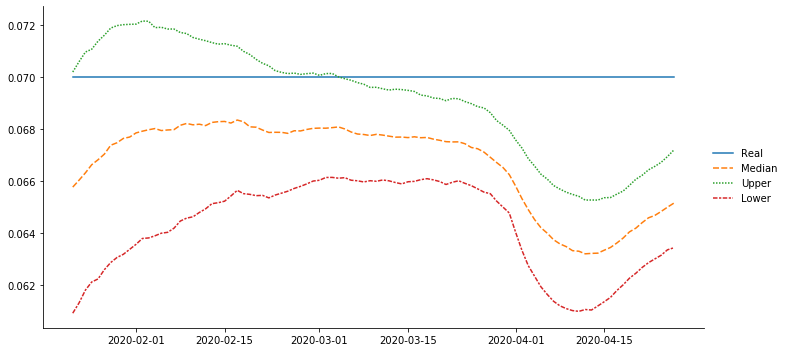

In [263]:
draw(b_sim, real=0.07)

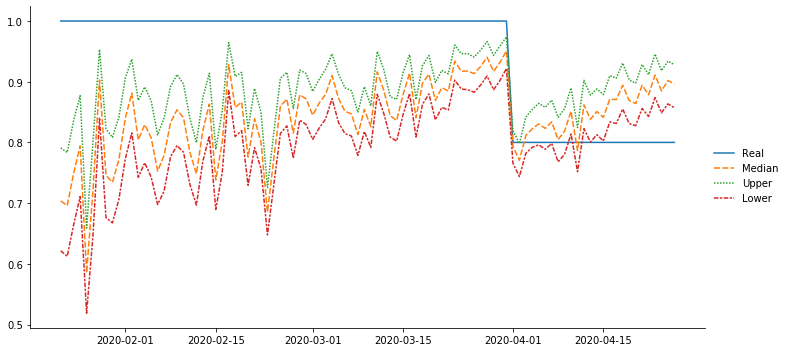

In [264]:
q = pd.Series(data_sim['q'], index)
draw(q_sim, real=q)

In [265]:
# Train the model and generate samples
inits = 'random'
data_sim['q0']=1
fit_const_q = sm_const_q.sampling(data=data_sim, iter=iteration, init=inits)
inf_const_q = az.from_pystan(fit_const_q, log_likelihood='log_lik')
fit_const_q


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_9dd31a91ba2222187c48a952f7561ebe.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf 1004.5    3.04  29.12 951.63 984.04 1002.3 1024.9 1064.3     92   1.08
b_beta   6.6e-4  2.6e-5 1.8e-4 3.6e-4 5.2e-4 6.4e-4 7.7e-4 1.1e-3     47   1.04
b[1]       0.07  3.5e-4 3.0e-3   0.06   0.07   0.07   0.07   0.08     74   1.06
b[2]       0.07  3.4e-4 2.8e-3   0.07   0.07   0.07   0.07   0.08     69   1.07
b[3]       0.07  3.3e-4 2.7e-3   0.07   0.07   0.07   0.07   0.08     68   1.07
b[4]       0.07  3.1e-4 2.6e-3   0.07   0.07   0.07   0.07   0.08     70   1.07
b[5]       0.07  3.1e-4 2.5e-3   0.07   0.07   0.07   0.07   0.08     67   1.08
b[6]       0.07  3.0e-4 2.4e-3   0.07   0.07   0.07   0.07   0.08     64   1.09
b[7]       0.07  2.7e-4 2.2e-3   0.07   0.07   0.07

In [266]:
b_const_q = pd.DataFrame(inf_const_q.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)

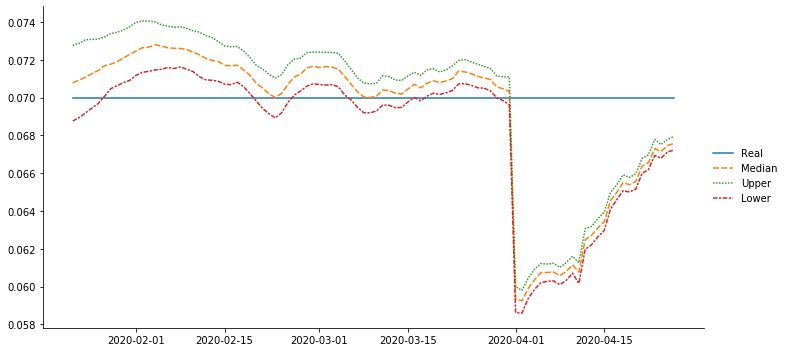

In [267]:
draw(b_const_q, real=0.07)

In [268]:
from scipy.stats import poisson
def simulate_noisy(b, q0, init_inf, a, d, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q0)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        q = q0 + 0.1*np.random.randn(1)
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        C = C+NI
        I = I + NI - NR - ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        R_obs.append(int(R_obs[-1]+poisson.rvs(a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
    return {'C0':np.array(C_obs), 'R0':np.array(R_obs), 'D0':np.array(D_obs), 'T':C0.shape[0], 'T0':0, 'P':P, 'b_beta_0':1}

In [269]:
data_sim = simulate_noisy(0.07, 0.5, 1000, 0.01, 0.001, index)

In [270]:
# Train the model and generate samples
inits = 'random'
fit_sim = sm_every.sampling(data=data_sim, iter=iteration, init=inits)
inf_sim = az.from_pystan(fit_sim, log_likelihood='log_lik')
fit_sim


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_932cdbcc72157dc97c0d1bb55a6ba937.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf 776.53    5.92  186.4 530.69 634.78 741.02 885.49 1222.8    990    1.0
b_beta   3.2e-3  8.5e-5 1.2e-3 1.3e-3 2.4e-3 3.1e-3 3.9e-3 6.0e-3    192   1.03
b[1]       0.07  2.9e-4   0.01   0.05   0.06   0.07   0.07   0.09   1696    1.0
b[2]       0.07  2.9e-4   0.01   0.05   0.06   0.07   0.08   0.09   1715    1.0
b[3]       0.07  3.0e-4   0.01   0.05   0.06   0.07   0.08   0.09   1611    1.0
b[4]       0.07  3.2e-4   0.01   0.05   0.06   0.07   0.08   0.09   1413    1.0
b[5]       0.07  3.3e-4   0.01   0.05   0.06   0.07   0.08    0.1   1278    1.0
b[6]       0.07  3.5e-4   0.01   0.05   0.07   0.07   0.08    0.1   1128    1.0
b[7]       0.08  3.7e-4   0.01   0.05   0.07   0.07

In [271]:
b_sim = pd.DataFrame(inf_sim.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
q_sim = pd.DataFrame(inf_sim.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)

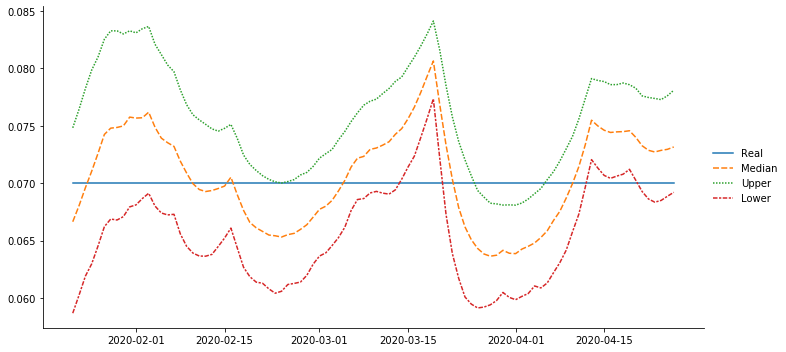

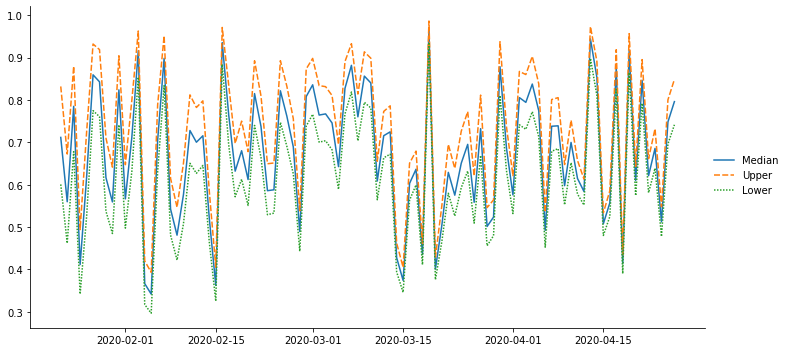

In [272]:
draw(b_sim, real=0.07)
draw(q_sim)

In [273]:
# Train the model and generate samples
inits = 'random'
data_sim['q0']=1
fit_const_q = sm_const_q.sampling(data=data_sim, iter=iteration, init=inits)
inf_const_q = az.from_pystan(fit_const_q, log_likelihood='log_lik')
fit_const_q


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_9dd31a91ba2222187c48a952f7561ebe.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf 525.12    1.87  23.29 479.52 509.23 525.36 540.79 568.57    155   1.01
b_beta     0.02  1.2e-4 1.9e-3   0.01   0.02   0.02   0.02   0.02    244   1.01
b[1]       0.06  9.4e-4   0.01   0.04   0.05   0.06   0.07   0.08    151   1.01
b[2]       0.06  1.0e-3   0.01   0.04   0.05   0.06   0.07   0.08    114   1.02
b[3]       0.07  1.2e-3   0.01   0.05   0.06   0.07   0.08   0.09     88   1.01
b[4]       0.06  1.3e-3   0.01   0.03   0.05   0.06   0.06   0.08     83   1.01
b[5]       0.07  1.2e-3   0.01   0.05   0.06   0.07   0.08   0.09     81   1.06
b[6]       0.09  9.6e-4   0.01   0.07   0.08   0.09   0.09   0.11    160   1.03
b[7]       0.09  7.6e-4   0.01   0.07   0.08   0.09

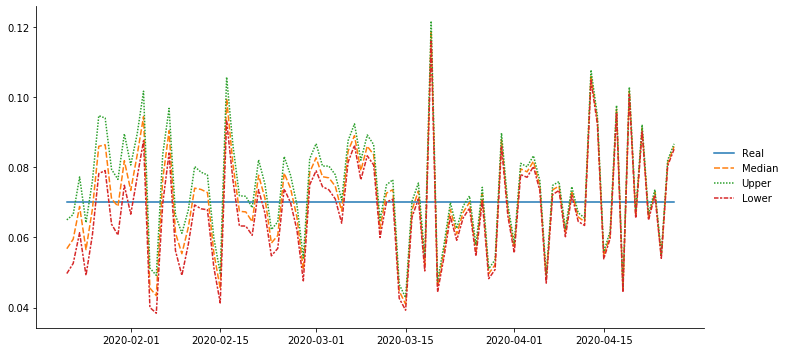

In [274]:
b_sim = pd.DataFrame(inf_const_q.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
draw(b_sim, real=0.07)

In [275]:
from scipy.stats import poisson
def simulate_trend(b0, b1, q0, init_inf, a, d, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q0)]
    R_obs = [0]
    D_obs = [0]
    b = [b0]
    for t in index:
        q = q0 + 0.05*np.random.randn(1)
        NI = poisson.rvs(b[-1]*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        C = C+NI
        I = I + NI - NR - ND
        b.append(b[-1] - b1)
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        R_obs.append(int(R_obs[-1]+poisson.rvs(a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
    return {'C0':np.array(C_obs), 'R0':np.array(R_obs), 'D0':np.array(D_obs), 
            'T':C0.shape[0], 'T0':0, 'P':P, 'b_beta_0':1, 'b':np.array(b)}

In [276]:
data_sim = simulate_trend(0.16, 0.001, 0.5, 1000, 0.01, 0.001, index)

In [277]:
inits = 'random'
fit_sim = sm_every.sampling(data=data_sim, iter=iteration, init=inits)
inf_sim = az.from_pystan(fit_sim, log_likelihood='log_lik')
fit_sim


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_932cdbcc72157dc97c0d1bb55a6ba937.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf 1004.4   14.17 230.65 656.06 843.74 969.89 1122.7 1565.5    265   1.01
b_beta   3.3e-3  7.1e-5 1.1e-3 1.7e-3 2.5e-3 3.1e-3 3.8e-3 5.9e-3    219   1.01
b[1]       0.13  7.2e-4   0.02   0.09   0.11   0.13   0.14   0.16    493    1.0
b[2]       0.13  7.4e-4   0.02   0.09   0.12   0.13   0.14   0.16    468    1.0
b[3]       0.13  7.6e-4   0.02    0.1   0.12   0.13   0.14   0.16    441    1.0
b[4]       0.13  7.6e-4   0.02    0.1   0.12   0.13   0.14   0.16    430    1.0
b[5]       0.13  7.6e-4   0.02    0.1   0.12   0.13   0.14   0.16    417    1.0
b[6]       0.13  7.5e-4   0.02    0.1   0.12   0.13   0.14   0.16    406    1.0
b[7]       0.13  7.1e-4   0.01    0.1   0.12   0.13

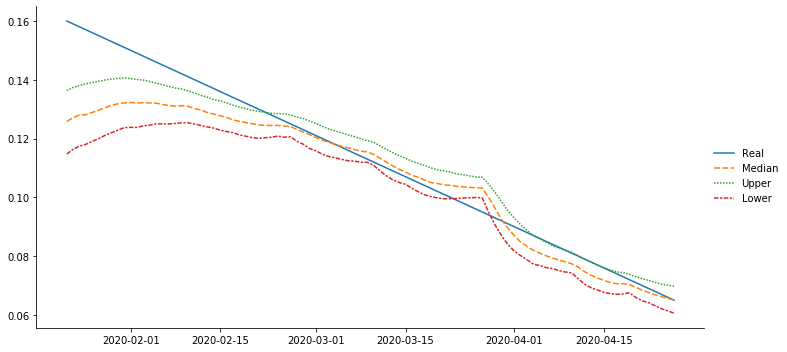

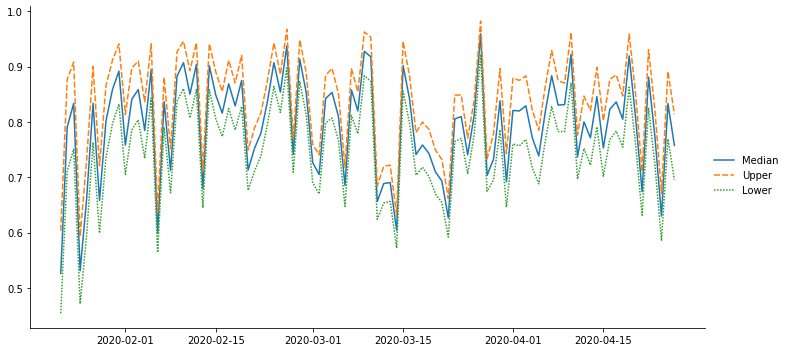

In [282]:
b_sim = pd.DataFrame(inf_sim.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
q_sim = pd.DataFrame(inf_sim.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)
b = pd.Series(data_sim['b'][:-1], index)
draw(b_sim, real=b)
draw(q_sim)

In [283]:
# Train the model and generate samples
inits = 'random'
data_sim['q0']=1
fit_const_q = sm_const_q.sampling(data=data_sim, iter=iteration, init=inits)
inf_const_q = az.from_pystan(fit_const_q, log_likelihood='log_lik')
fit_const_q


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_9dd31a91ba2222187c48a952f7561ebe.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf 514.57    9.54  18.37 481.51 501.91 510.68 534.96 544.59      4   1.58
b_beta     0.01  3.5e-4 8.6e-4 9.5e-310.0e-3   0.01   0.01   0.01      6   1.35
b[1]       0.15  3.9e-3   0.01   0.12   0.15   0.16   0.16   0.17     12   1.32
b[2]       0.16  2.9e-3   0.01   0.14   0.15   0.16   0.17   0.18     13   1.35
b[3]       0.16  8.8e-3   0.02   0.14   0.15   0.16   0.18   0.18      3   2.14
b[4]       0.15  3.7e-3   0.01   0.12   0.14   0.15   0.15   0.17      8   1.43
b[5]       0.15  7.4e-3   0.01   0.14   0.14   0.14   0.16   0.18      3   1.93
b[6]       0.16  4.3e-3 8.7e-3   0.15   0.16   0.16   0.17   0.18      4   1.59
b[7]       0.16  1.3e-3 6.7e-3   0.14   0.15   0.15

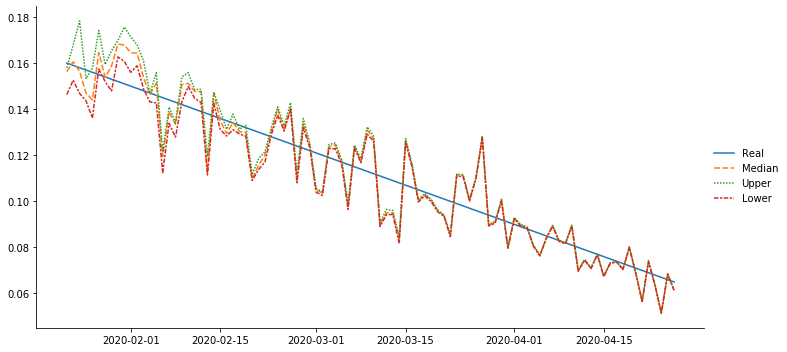

In [284]:
b_const_q = pd.DataFrame(inf_const_q.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
draw(b_const_q, real=b)

In [285]:
data_sim = simulate_trend(0.01, -0.001, 0.5, 1000, 0.01, 0.001, index)

In [286]:
inits = 'random'
fit_sim = sm_every.sampling(data=data_sim, iter=iteration, init=inits)
inf_sim = az.from_pystan(fit_sim, log_likelihood='log_lik')
fit_sim


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_932cdbcc72157dc97c0d1bb55a6ba937.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf  593.6    4.26 125.05 458.84 508.82 558.38 642.85 919.88    864    1.0
b_beta   3.0e-3  2.8e-5 7.2e-4 1.8e-3 2.4e-3 2.9e-3 3.4e-3 4.7e-3    640    1.0
b[1]     8.4e-3  8.7e-5 5.2e-3 1.5e-3 4.5e-3 7.3e-3   0.01   0.02   3553    1.0
b[2]       0.02  1.3e-4 5.9e-3 8.2e-3   0.01   0.02   0.02   0.03   2201    1.0
b[3]       0.02  1.3e-4 5.8e-3 8.8e-3   0.01   0.02   0.02   0.03   1925    1.0
b[4]       0.02  1.4e-4 5.9e-3 8.8e-3   0.01   0.02   0.02   0.03   1708    1.0
b[5]       0.02  1.4e-4 6.0e-3 9.1e-3   0.02   0.02   0.02   0.03   1758    1.0
b[6]       0.02  1.5e-4 5.8e-3   0.01   0.02   0.02   0.02   0.03   1514    1.0
b[7]       0.02  1.5e-4 5.9e-3   0.01   0.02   0.02

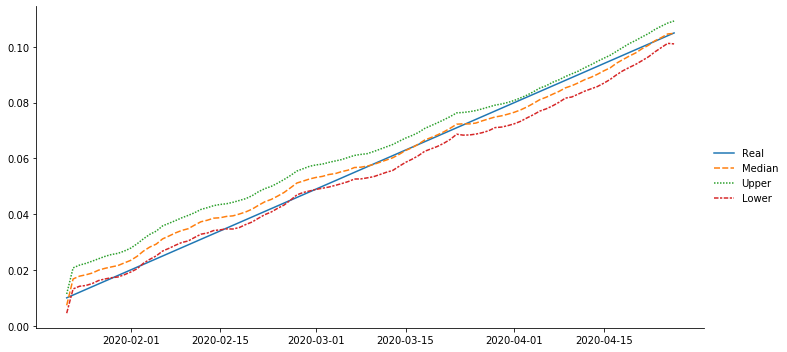

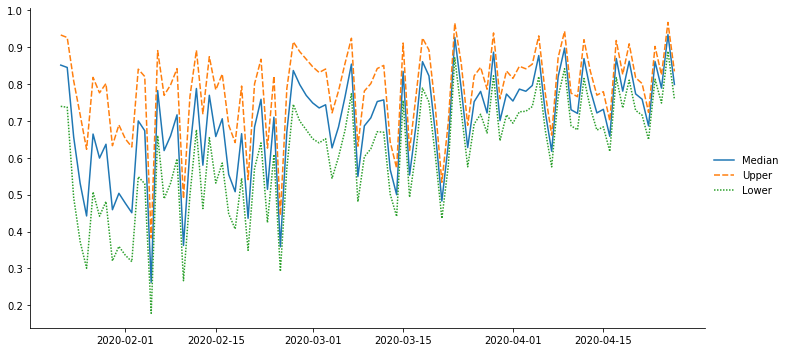

In [288]:
b_sim = pd.DataFrame(inf_sim.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
q_sim = pd.DataFrame(inf_sim.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)
b = pd.Series(data_sim['b'][:-1], index)
draw(b_sim, b)
draw(q_sim)

In [289]:
# Train the model and generate samples
inits = 'random'
data_sim['q0']=1
fit_const_q = sm_const_q.sampling(data=data_sim, iter=iteration, init=inits)
inf_const_q = az.from_pystan(fit_const_q, log_likelihood='log_lik')
fit_const_q


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_9dd31a91ba2222187c48a952f7561ebe.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf 467.26    1.55  21.35 425.68 452.14 467.21 482.18 508.18    190   1.01
b_beta   5.7e-3  1.5e-4 1.1e-3 3.9e-3 4.9e-3 5.7e-3 6.3e-3 8.3e-3     58   1.09
b[1]     9.0e-3  4.4e-4 4.6e-3 2.4e-3 5.7e-3 8.2e-3   0.01   0.02    105   1.05
b[2]       0.02  5.2e-4 4.7e-3 7.3e-3   0.01   0.02   0.02   0.03     83   1.02
b[3]       0.02  4.0e-4 4.2e-3 8.4e-3   0.01   0.02   0.02   0.02    106   1.05
b[4]       0.01  7.5e-4 4.6e-3 6.3e-3   0.01   0.01   0.02   0.02     38   1.12
b[5]       0.01  5.3e-4 4.7e-3 5.1e-3   0.01   0.01   0.02   0.02     78   1.07
b[6]       0.02  3.8e-4 4.7e-3 8.1e-3   0.01   0.02   0.02   0.03    153   1.01
b[7]       0.02  4.9e-4 4.8e-3 9.0e-3   0.01   0.02

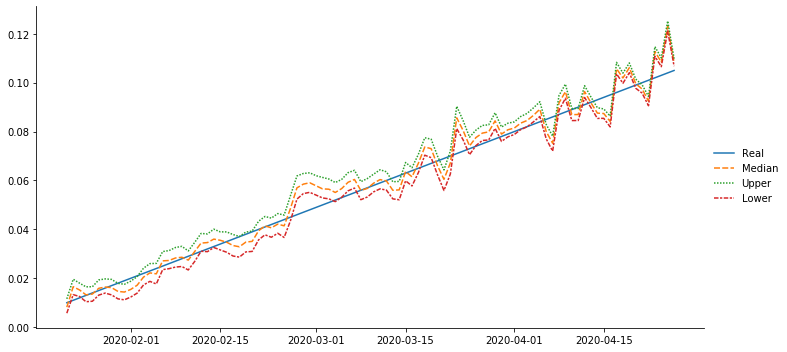

In [290]:
b_const_q = pd.DataFrame(inf_const_q.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
draw(b_const_q, real=b)

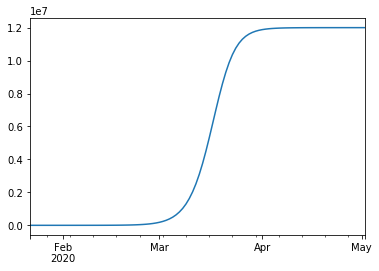

In [303]:
data_sim = simulate_const(0.3, 0.1, 100, 0.01, 0.001, index)
pd.Series(data_sim['C0'][:-1], index).plot()

In [304]:
# Train the model and generate samples
inits = 'random'
fit_sim = sm_every.sampling(data=data_sim, iter=iteration, init=inits)
inf_sim = az.from_pystan(fit_sim, log_likelihood='log_lik')
fit_sim


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_932cdbcc72157dc97c0d1bb55a6ba937.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   8.54    2.38   4.48   0.34   5.72   8.83  11.33  17.48      4   1.63
b_beta   3.4e-3  9.7e-4 1.6e-3 5.2e-4 2.3e-3 3.6e-3 4.5e-3 6.2e-3      3   2.09
b[1]       0.38    0.09   0.21   0.25   0.28    0.3   0.33   1.04      5   2.71
b[2]       0.38    0.09   0.21   0.25   0.28    0.3   0.33   1.03      5   2.72
b[3]       0.38    0.09   0.21   0.25   0.29    0.3   0.33   1.04      5   2.73
b[4]       0.38    0.09   0.21   0.26   0.29    0.3   0.33   1.04      5   2.73
b[5]       0.38    0.09   0.21   0.26   0.29    0.3   0.33   1.04      5   2.73
b[6]       0.38    0.09   0.21   0.26   0.29    0.3   0.33   1.03      5   2.73
b[7]       0.38    0.09   0.21   0.26   0.29    0.3

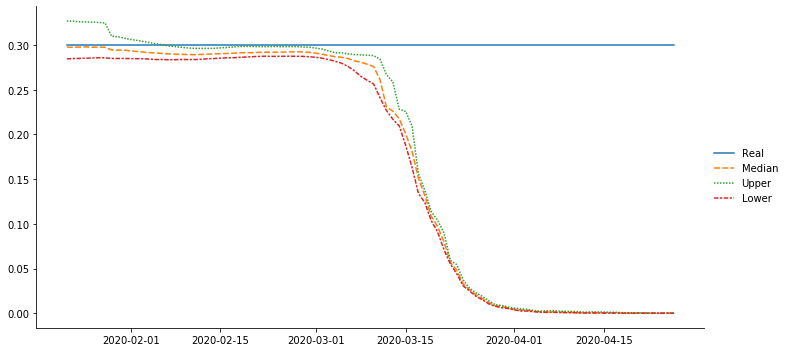

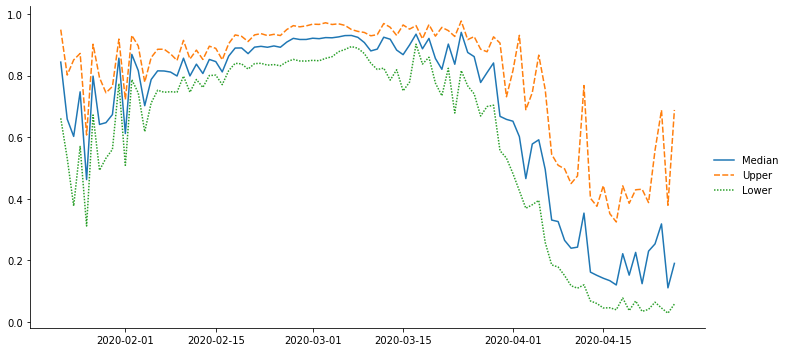

In [305]:
b_sim = pd.DataFrame(inf_sim.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
q_sim = pd.DataFrame(inf_sim.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)
draw(b_sim, real=0.3)
draw(q_sim)